In [2]:
import spacy
spacy_nlp = spacy.load("en_core_web_sm")
import utility_functions_topic_modeling as utils
import importlib
import pandas as pd
import seaborn as sns


# Text processing
from gensim import corpora

# Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

importlib.reload(utils)

data_path = '../Data/dataframes/preprocessed_df.pkl'

In [3]:
df = pd.read_pickle(data_path)
df[['Artist', 'Song', 'Tokens', 'Lyrics', 'Coast']].head()

,Artist,Song,Tokens,Lyrics,Coast
0,Big L,8 Iz Enuff.mp3,"[crew, house, bless, big, mike, imma, set, fol...","\n\nYo\nMy crew is in the house\nTerra, Herb M...",east_coast
1,Big L,Da Graveyard.mp3,"[number, one, crew, big, nigga, men, win, kill...",\n\n[Intro:]\nIt's the number one crew in the ...,east_coast
2,Big L,I Don't Understand It.mp3,"[many, mcs, ask, even, supposed, make, rap, kn...",\n\n[Verse 1]\nThere are too many MC's who are...,east_coast
3,Big L,"No Endz, No Skinz.mp3","[let, point, real, quick, pocket, thick, mad, ...",\n\n[Verse 1:]\nLet me get to the point real q...,east_coast
4,Big L,MVP.mp3,"[pass, make, quick, money, grip, ass, street, ...",\n\n[Big L]\n A yo spark up the phillies and p...,east_coast


In [4]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['Tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
print(f"Number of unique tokens: {len(dictionary)}")

Number of unique tokens: 921


In [5]:
# Convert documents to a bag-of-words representation
corpus = [dictionary.doc2bow(text) for text in df['Tokens']]

In [6]:
start = 2
limit = 6
step = 1
chunksize = 200
passes = 15
iterations = 100
eval_every = 10

model_list, coherence_values = utils.compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=df['Tokens'],
    start=start,
    limit=limit,
    step=step,
    chunksize=chunksize,
    passes=passes,
    iterations=iterations,
    eval_every=eval_every
)

Computing coherence: 100%|██████████| 4/4 [00:24<00:00,  6.21s/it]


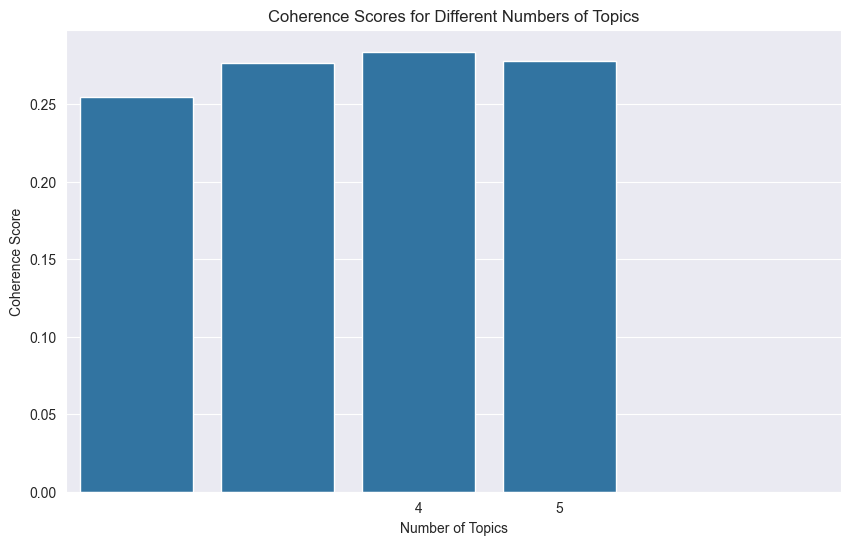

In [7]:
# Prepare data for Seaborn
x = list(range(start, limit, step))

# Create a barplot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=x, y=coherence_values)

# Set plot labels and title
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of Topics")

plt.xticks(ticks=range(start, limit, step))

plt.show()

In [8]:
# Select the model with highest coherence
optimal_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_index]
optimal_num_topics = x[optimal_index]

print(f'Optimal Number of Topics: {optimal_num_topics}')
print(f'Highest Coherence Score: {coherence_values[optimal_index]:.4f}')

Optimal Number of Topics: 4
Highest Coherence Score: 0.2839


In [9]:
# Prepare the visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis)

In [10]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
        # Get the dominant topic, its percentage, and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Only the dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])

                # Creating a temporary DataFrame to hold the new row
                temp_df = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]],
                                       columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

                # Use pd.concat() instead of append
                sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)

            else:
                break

    # Add original text to the DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename('Text')], axis=1)

    return sent_topics_df

# Apply the updated function
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=optimal_model,
    corpus=corpus,
    texts=df['Lyrics']
)

# Format the output
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Display the result
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.4467,"rhyme, rap, rock, keep, mic, check, move, stop...","\n\nYo\nMy crew is in the house\nTerra, Herb M..."
1,1,1,0.5864,"fuck, bitch, motherfucker, ass, hit, roll, giv...",\n\n[Intro:]\nIt's the number one crew in the ...
2,2,2,0.7749,"rhyme, rap, rock, keep, mic, check, move, stop...",\n\n[Verse 1]\nThere are too many MC's who are...
3,3,3,0.6271,"girl, said, baby, would, look, around, call, w...",\n\n[Verse 1:]\nLet me get to the point real q...
4,4,2,0.3542,"rhyme, rap, rock, keep, mic, check, move, stop...",\n\n[Big L]\n A yo spark up the phillies and p...


In [11]:
# Assuming you have a 'Region' column indicating 'East' or 'West'
df_dominant_topic['Coast'] = df['Coast']

# Calculate the distribution of topics by region (East vs West) in percentages
topic_region_dist = pd.crosstab(df_dominant_topic['Dominant_Topic'],
                                df_dominant_topic['Coast'],
                                normalize='index') * 100
print(topic_region_dist)

Coast           east_coast  west_coast
Dominant_Topic                        
0                57.348703   42.651297
1                24.709302   75.290698
2                70.065076   29.934924
3                43.981481   56.018519


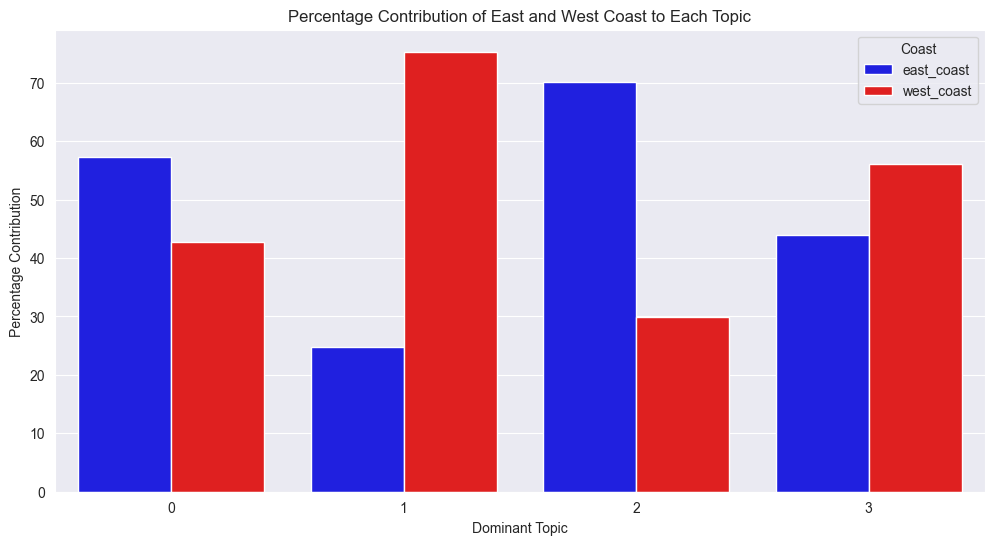

In [12]:
# Reset the index to convert 'Dominant_Topic' from index to column
topic_region_dist = topic_region_dist.reset_index()

# Melt the DataFrame for easier plotting with seaborn
topic_region_dist_melted = topic_region_dist.melt(id_vars='Dominant_Topic',
                                                  value_vars=['east_coast', 'west_coast'],
                                                  var_name='Coast',
                                                  value_name='Percentage')

# Define custom colors for East Coast (blue) and West Coast (red)
palette = {"east_coast": "blue", "west_coast": "red"}

# Create the bar plot with custom colors
plt.figure(figsize=(12, 6))
sns.barplot(x='Dominant_Topic', y='Percentage', hue='Coast', data=topic_region_dist_melted, palette=palette)

# Set plot labels and title
plt.xlabel("Dominant Topic")
plt.ylabel("Percentage Contribution")
plt.title("Percentage Contribution of East and West Coast to Each Topic")

# Show the plot
plt.show()

In [13]:
df.head()

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,Lyrics,Tokens,Processed_Lyrics
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"\n\nYo\nMy crew is in the house\nTerra, Herb M...","[crew, house, bless, big, mike, imma, set, fol...",crew house terra herb mcgruff buddah bless big...
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,\n\n[Intro:]\nIt's the number one crew in the ...,"[number, one, crew, big, nigga, men, win, kill...",number one crew area big lightin nigga incense...
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,\n\n[Verse 1]\nThere are too many MC's who are...,"[many, mcs, ask, even, supposed, make, rap, kn...",many mcs overrated ask even supposed make rap ...
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,\n\n[Verse 1:]\nLet me get to the point real q...,"[let, point, real, quick, pocket, thick, mad, ...",let get point real quick pocket thick mad chic...
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,\n\n[Big L]\n A yo spark up the phillies and p...,"[pass, make, quick, money, grip, ass, street, ...",spark phillies pass stout make quick money gri...
